In [1]:
import time
import pandas as pd
import pickle
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
chrome_options = Options()
chrome_prefs = {"profile.managed_default_content_settings.images": 2}
chrome_options.add_experimental_option("prefs", chrome_prefs)
chrome_options.add_argument("--start-maximized")
chrome_options.add_argument("--disable-notifications")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

driver.set_script_timeout(30)

In [3]:
# Open the URL
url = "https://bsky.app/profile/jaz.bsky.social/feed/top-24h"
url = "https://bsky.app/profile/bsky.app/feed/hot-classic"
# url = "https://bsky.app/"
driver.get(url)

In [7]:
def save_posts(posts):
    with open("posts.pkl", "ab") as f: 
        pickle.dump(posts, f)

In [ ]:
seen_posts = set()
try:
    last_height = driver.execute_script("return document.body.scrollHeight")
    all_posts = []
    
    time.sleep(10)

    while True:
        # Scroll down to the bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(0.3) 

        posts = driver.find_elements(By.XPATH, "//div[@data-testid='postText']")
        post_texts = [post.text for post in posts if post.text.strip()]

        new_posts = [post for post in post_texts if post not in seen_posts]
        
        if new_posts:
            all_posts.extend(new_posts)  
            save_posts(new_posts)  
            for post in new_posts:
                seen_posts.add(post) 
            print(f"Saved {len(new_posts)} new posts...")

        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            print("Reached the end of the page.")
            break
        last_height = new_height

except KeyboardInterrupt:
    print("\nScrolling stopped - Saving remaining posts...")

driver.quit()

print(f"Total posts saved to posts.pkl: {len(all_posts)}")


In [243]:
# load the pickle 
with open("posts.pkl", "rb") as f:
    posts = []
    while True:
        try:
            posts.extend(pickle.load(f))
        except EOFError:
            break
    
        
df = pd.DataFrame(posts, columns=["Posts"])

In [244]:
df

,Posts
0,"Firefighting crews from Mexico, Canada, South ..."
1,Watched Tampopo yesterday
2,New Nerd and Jock Exclusive Episode! Two Nerds...
3,"""One reason many federal employees are thinkin..."
4,Merrick Garland has an easy path to immediatel...
...,...
7979,Official portraits all look the same.
7980,Colorado elk! Pagosa Springs 📸🏔️
7981,If people keep making fun of Elon Musk for bei...
7982,Wait I didn't know we were allowed to do that


# Processing


In [245]:
df["Word Count"] = df["Posts"].str.split().str.len()
df["Character Count"] = df["Posts"].str.len()

avg_word_count = df["Word Count"].mean()
avg_char_count = df["Character Count"].mean()

print(f"Average word count per post: {avg_word_count:.2f}")
print(f"Average character count per post: {avg_char_count:.2f}")

Average word count per post: 22.54
Average character count per post: 136.34


In [246]:
# remove posts with empty text or less than 10 words
df = df[df["Posts"].str.split().str.len() > 10]

In [247]:
df

,Posts,Word Count,Character Count
0,"Firefighting crews from Mexico, Canada, South ...",33,206
2,New Nerd and Jock Exclusive Episode! Two Nerds...,17,122
3,"""One reason many federal employees are thinkin...",29,215
4,Merrick Garland has an easy path to immediatel...,20,115
5,"📌Just read this chilling article, and the para...",48,297
...,...,...,...
7975,"Today is an angry day, friends. We could all b...",52,298
7976,i've only had cappie miside for 1 hour but if ...,24,119
7978,Good morning. \n\nWe head to an image from 202...,13,75
7981,If people keep making fun of Elon Musk for bei...,39,187


In [248]:
#remove links from posts, https, www, .com, .org, .net

df["Posts"] = df["Posts"].str.replace(r"http\S+", "", regex=True)
df["Posts"] = df["Posts"].str.replace(r"www\S+", "", regex=True)
df["Posts"] = df["Posts"].str.replace(r"\.com", "", regex=True)
df["Posts"] = df["Posts"].str.replace(r"\.org", "", regex=True)
df["Posts"] = df["Posts"].str.replace(r"\.net", "", regex=True)

In [249]:
import emoji
import re

def convert_emoji_to_text(post_text):
    post_text = emoji.demojize(post_text)
    
    emoji_pattern = r"(:\w+:)"
    found_emojis = re.findall(emoji_pattern, post_text)
    unique_emojis = set(found_emojis)  
    
    for emoji_text in found_emojis:
        post_text = post_text.replace(emoji_text, "") 

    for unique_emoji in unique_emojis:
        post_text += unique_emoji 
    
    return post_text

def remove_emojis(post_text):
    return post_text.encode('ascii', 'ignore').decode('ascii')


df["processed_post_text"] = df["Posts"].apply(remove_emojis)

In [250]:
df

,Posts,Word Count,Character Count,processed_post_text
0,"Firefighting crews from Mexico, Canada, South ...",33,206,"Firefighting crews from Mexico, Canada, South ..."
2,New Nerd and Jock Exclusive Episode! Two Nerds...,17,122,New Nerd and Jock Exclusive Episode! Two Nerds...
3,"""One reason many federal employees are thinkin...",29,215,"""One reason many federal employees are thinkin..."
4,Merrick Garland has an easy path to immediatel...,20,115,Merrick Garland has an easy path to immediatel...
5,"📌Just read this chilling article, and the para...",48,297,"Just read this chilling article, and the paral..."
...,...,...,...,...
7975,"Today is an angry day, friends. We could all b...",52,298,"Today is an angry day, friends. We could all b..."
7976,i've only had cappie miside for 1 hour but if ...,24,119,i've only had cappie miside for 1 hour but if ...
7978,Good morning. \n\nWe head to an image from 202...,13,75,Good morning. \n\nWe head to an image from 202...
7981,If people keep making fun of Elon Musk for bei...,39,187,If people keep making fun of Elon Musk for bei...


In [251]:
import spacy

nlp = spacy.load("en_core_web_sm")

def process_text(post_text):
    doc = nlp(post_text)
    processed_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    processed_text = processed_text.replace("\n", "")
    return processed_text

df["processed_post_text"] = df["processed_post_text"].apply(process_text)

In [252]:
df

,Posts,Word Count,Character Count,processed_post_text
0,"Firefighting crews from Mexico, Canada, South ...",33,206,firefighting crew Mexico Canada South Africas ...
2,New Nerd and Jock Exclusive Episode! Two Nerds...,17,122,New Nerd Jock Exclusive Episode nerd happen fi...
3,"""One reason many federal employees are thinkin...",29,215,reason federal employee think leave government...
4,Merrick Garland has an easy path to immediatel...,20,115,Merrick Garland easy path immediately release ...
5,"📌Just read this chilling article, and the para...",48,297,read chilling article parallel today breathtak...
...,...,...,...,...
7975,"Today is an angry day, friends. We could all b...",52,298,today angry day friend create beautiful thing ...
7976,i've only had cappie miside for 1 hour but if ...,24,119,cappie miside 1 hour happen kill game
7978,Good morning. \n\nWe head to an image from 202...,13,75,good morning head image 2024 today take North...
7981,If people keep making fun of Elon Musk for bei...,39,187,people make fun Elon Musk fake gamer think abl...


In [253]:
# Split the text into individual words
df["word_list"] = df["processed_post_text"].str.split()

In [254]:
from sentence_transformers import SentenceTransformer

docs: list[str] = df['processed_post_text'].tolist()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = embedding_model.encode(docs)


In [255]:
embeddings.shape

(5601, 384)

In [256]:
from umap import UMAP

umap_model = UMAP(
    n_neighbors=20,
    n_components=2,
    min_dist=0.0,
    metric='cosine',
)

In [257]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size=15,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

In [258]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer_model = CountVectorizer(
    ngram_range=(1, 6),
    analyzer='word',
    min_df=1,
)

In [259]:
from bertopic.vectorizers import ClassTfidfTransformer

ctfidf_model = ClassTfidfTransformer()


In [260]:
import wget
from pathlib import Path

filename_llm = "openhermes-2.5-mistral-7b.Q2_K.gguf"
if Path(filename_llm).is_file():
    print(f"Model {filename_llm} exists.")

else:
    #url = 'https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q2_K.gguf'
    url = 'https://huggingface.co/unsloth/Llama-3.2-1B-Instruct-GGUF/resolve/main/Llama-3.2-1B-Instruct-Q4_K_M.gguf'
    filename_llm = wget.download(url)
    print(f"Model {filename_llm} downloaded.")

Model openhermes-2.5-mistral-7b.Q2_K.gguf exists.


In [261]:
from llama_cpp import Llama

llm = Llama(
    model_path=filename_llm,
    n_gpu_layers=-1,
    n_ctx=4096,
    stop=["Q:", "\n"]
)

llama_model_load_from_file: using device Metal (Apple M1) - 3145 MiB free
llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from openhermes-2.5-mistral-7b.Q2_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_coun

In [262]:
from bertopic.representation import KeyBERTInspired, LlamaCPP, MaximalMarginalRelevance, PartOfSpeech

prompt = """Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short general topic label of at most 5 words?

A:
"""

representation_model = {
    "LLM": LlamaCPP(llm, prompt=prompt),  
    "KeyBERT": KeyBERTInspired(),
    "Aspect1": PartOfSpeech("en_core_web_trf"),
    "Aspect2": KeyBERTInspired(top_n_words=10),
}

In [263]:
from bertopic import BERTopic

topic_model = BERTopic(
  language="english",

  embedding_model=embedding_model,          
  umap_model=umap_model,                     
  hdbscan_model=hdbscan_model,                
  vectorizer_model=vectorizer_model,         
  ctfidf_model=ctfidf_model,    
  representation_model=representation_model,  

  top_n_words=10,
  verbose=True,
  calculate_probabilities=True,
)

topics, probs = topic_model.fit_transform(
    docs,
    embeddings,
)

ggml_metal_free: deallocating
2025-01-18 23:21:34,956 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-18 23:21:37,151 - BERTopic - Dimensionality - Completed ✓
2025-01-18 23:21:37,152 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-18 23:21:37,806 - BERTopic - Cluster - Completed ✓
2025-01-18 23:21:37,810 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/62 [00:00<?, ?it/s]llama_perf_context_print:        load time =    5115.96 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   248 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    6328.67 ms /   263 tokens
  2%|▏         | 1/62 [00:06<06:27,  6.36s/it]Llama.generate: 16 prefix-match hit, remaining 215 prompt tokens to eval


In [264]:
topic_model.get_topic(23)

[('zuckerberg', np.float64(0.01363396060126882)),
 ('fact', np.float64(0.010817425186246322)),
 ('mark', np.float64(0.009840493856155767)),
 ('journalism', np.float64(0.009026111138265095)),
 ('masculine', np.float64(0.008485338113257569)),
 ('masculine energy', np.float64(0.00773666668994151)),
 ('lie', np.float64(0.007589406539554589)),
 ('energy', np.float64(0.007179190731103728)),
 ('say', np.float64(0.006588823061729575)),
 ('news', np.float64(0.006517028268641448))]

In [265]:
#topic_model.visualize_document_datamap(docs, embeddings=embeddings)

In [266]:
#topic_model.visualize_topics()

In [267]:
num_topics = len(topic_model.get_topics()) - 1

print(f"Number of topics: {num_topics}")

Number of topics: 61


In [268]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    topics_info_df = topics_info_df.set_index('Topic')
    cols = topics_info_df.columns.tolist()

    return topics_info_df[cols + extra_cols]

In [269]:
df_topic_info = get_topic_stats(topic_model)

In [270]:
df_topic_info

,Count,Name,Representation,LLM,KeyBERT,Aspect1,Aspect2,Representative_Docs,Share,CumulativeShare
Topic,,,,,,,,,,
-1,2279,-1_like_people_day_social,"[like, people, day, social, not, time, year, n...",[Disability and Healthcare\n\nExplanation:\nTh...,"[social, bsky social, write, support, governme...","[people, day, social, time, year, new, good, t...","[social, bsky social, write, support, governme...",[selling buy house remarkably like go college ...,40.689163,40.689163
0,232,0_ai_like_feel_people,"[ai, like, feel, people, life, post, thing, th...","[Artificial Intelligence, Leadership, Reading,...","[ai, article, brain, follow, read, heart, inve...","[people, life, post, thing, love, time, year, ...","[ai, article, brain, follow, read, heart, inve...",[click article run free article read subscr- ...,4.142117,44.831280
1,180,1_portfolioday_art_draw_artist,"[portfolioday, art, draw, artist, work, comic_...","[""Freelance Artists Portfolio Day"", , , , , , ...","[character designer, hi portfolioday, portfoli...","[art, draw, artist, work, comic_strip, illustr...","[character designer, hi portfolioday, portfoli...",[hello PortfolioDay m Jazzi freelance illu...,3.213712,48.044992
2,178,2_badenoch_brexit_labour_kemi,"[badenoch, brexit, labour, kemi, uk, tory, gov...","[""Kemi Badenoch, Triple Lock, and Tax"", , , , ...","[leader kemi badenoch, kemi badenoch, badenoch...","[brexit, labour, government, tax, party, conse...","[leader kemi badenoch, kemi badenoch, badenoch...",[new Lib Dems Kemi Badenoch come mother set s...,3.178004,51.222996
3,135,3_morning_good_day_good morning,"[morning, good, day, good morning, friday, sle...","[""Good Morning, Friend, and Weekend"", , , , , ...","[morning happy friday, day good morning, happy...","[morning, good, day, good morning, sleep, week...","[morning happy friday, day good morning, happy...",[thursday good day good morning friend the...,2.410284,53.633280
...,...,...,...,...,...,...,...,...,...,...
56,20,56_billionaire_pitt_athlete_school,"[billionaire, pitt, athlete, school, sport, tr...",[French Woman Scammer\n\nThe topic appears to ...,"[pay designer feather logo jacket bother, bezo...","[billionaire, athlete, school, sport, trans, f...","[pay designer feather logo jacket bother, bezo...",[fraud pose Brad Pitt mother allegedly scamme ...,0.357079,98.803785
57,18,57_contract_midfielder_allocation_allocation m...,"[contract, midfielder, allocation, allocation ...",[\nSoccer Player Transfer\n\nQ:\nI have a topi...,"[allocation money 150k intra league transfer, ...","[contract, allocation, midfielder, transfer, m...","[allocation money 150k intra league transfer, ...",[Official Jaeydn Shaw North Carolina San Deigo...,0.321371,99.125156
58,17,58_kryvyi rih_kryvyi_rih_attack kryvyi rih,"[kryvyi rih, kryvyi, rih, attack kryvyi rih, a...","[""Russian Attack Kryvyi Rih"", , , , , , , , , ]","[russian attack kryvyi rih kill injure, russia...","[attack, russian, missile, educational institu...","[russian attack kryvyi rih kill injure, russia...",[upd death toll rise 4 kill 5 wound russian mi...,0.303517,99.428673


In [271]:
df_outlier_topic = df_topic_info.loc[-1].copy(deep=True)

In [272]:
df_outlier_topic

Count                                                               2279
Name                                           -1_like_people_day_social
Representation         [like, people, day, social, not, time, year, n...
LLM                    [Disability and Healthcare\n\nExplanation:\nTh...
KeyBERT                [social, bsky social, write, support, governme...
Aspect1                [people, day, social, time, year, new, good, t...
Aspect2                [social, bsky social, write, support, governme...
Representative_Docs    [selling buy house remarkably like go college ...
Share                                                          40.689163
CumulativeShare                                                40.689163
Name: -1, dtype: object

In [273]:
non_outlier_documents = df_topic_info.drop(index=-1)['Count'].sum()
print(f"Number of non-outlier documents: {non_outlier_documents}")

outlier_documents = df_outlier_topic['Count'].sum(axis=0)
print(f"Number of outlier documents: {outlier_documents}")

print(f"Total number of documents: {non_outlier_documents + outlier_documents}")

p_outlier = outlier_documents / len(docs) * 100.
print(f"Percentage of outlier documents: {p_outlier:.2f}%")

Number of non-outlier documents: 3322
Number of outlier documents: 2279
Total number of documents: 5601
Percentage of outlier documents: 40.69%


In [274]:
# The shares without the outlier.
df_topic_info2 = df_topic_info.drop(index=-1)

df_topic_info2['Share'] = 100.*df_topic_info2['Count']/df_topic_info2['Count'].sum()
df_topic_info2['CumulativeShare'] = 100.*df_topic_info2['Count'].cumsum()/df_topic_info2['Count'].sum()

df_topic_info2

,Count,Name,Representation,LLM,KeyBERT,Aspect1,Aspect2,Representative_Docs,Share,CumulativeShare
Topic,,,,,,,,,,
0,232,0_ai_like_feel_people,"[ai, like, feel, people, life, post, thing, th...","[Artificial Intelligence, Leadership, Reading,...","[ai, article, brain, follow, read, heart, inve...","[people, life, post, thing, love, time, year, ...","[ai, article, brain, follow, read, heart, inve...",[click article run free article read subscr- ...,6.983745,6.983745
1,180,1_portfolioday_art_draw_artist,"[portfolioday, art, draw, artist, work, comic_...","[""Freelance Artists Portfolio Day"", , , , , , ...","[character designer, hi portfolioday, portfoli...","[art, draw, artist, work, comic_strip, illustr...","[character designer, hi portfolioday, portfoli...",[hello PortfolioDay m Jazzi freelance illu...,5.418423,12.402167
2,178,2_badenoch_brexit_labour_kemi,"[badenoch, brexit, labour, kemi, uk, tory, gov...","[""Kemi Badenoch, Triple Lock, and Tax"", , , , ...","[leader kemi badenoch, kemi badenoch, badenoch...","[brexit, labour, government, tax, party, conse...","[leader kemi badenoch, kemi badenoch, badenoch...",[new Lib Dems Kemi Badenoch come mother set s...,5.358218,17.760385
3,135,3_morning_good_day_good morning,"[morning, good, day, good morning, friday, sle...","[""Good Morning, Friend, and Weekend"", , , , , ...","[morning happy friday, day good morning, happy...","[morning, good, day, good morning, sleep, week...","[morning happy friday, day good morning, happy...",[thursday good day good morning friend the...,4.063817,21.824202
4,111,4_arsenal_penalty_united_game,"[arsenal, penalty, united, game, havertz, manc...","[""Manchester United vs. Arsenal Penalty Shooto...","[arsenal need, arsenal, manchester united, sec...","[arsenal, penalty, game, player, half, minute,...","[arsenal need, arsenal, manchester united, sec...",[real cup tie stuff second half game Penalty ...,3.341361,25.165563
...,...,...,...,...,...,...,...,...,...,...
56,20,56_billionaire_pitt_athlete_school,"[billionaire, pitt, athlete, school, sport, tr...",[French Woman Scammer\n\nThe topic appears to ...,"[pay designer feather logo jacket bother, bezo...","[billionaire, athlete, school, sport, trans, f...","[pay designer feather logo jacket bother, bezo...",[fraud pose Brad Pitt mother allegedly scamme ...,0.602047,97.983143
57,18,57_contract_midfielder_allocation_allocation m...,"[contract, midfielder, allocation, allocation ...",[\nSoccer Player Transfer\n\nQ:\nI have a topi...,"[allocation money 150k intra league transfer, ...","[contract, allocation, midfielder, transfer, m...","[allocation money 150k intra league transfer, ...",[Official Jaeydn Shaw North Carolina San Deigo...,0.541842,98.524985
58,17,58_kryvyi rih_kryvyi_rih_attack kryvyi rih,"[kryvyi rih, kryvyi, rih, attack kryvyi rih, a...","[""Russian Attack Kryvyi Rih"", , , , , , , , , ]","[russian attack kryvyi rih kill injure, russia...","[attack, russian, missile, educational institu...","[russian attack kryvyi rih kill injure, russia...",[upd death toll rise 4 kill 5 wound russian mi...,0.511740,99.036725


In [275]:
import re

llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]

all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
all_labels = [label.strip() for label in all_labels]

reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [276]:
all_labels

['Wildfires in California',
 'Podcast Trek Episode TV Kid TV',
 'Unlabelled',
 'Unlabelled',
 'Military Veteran and Fascism',
 'Unlabelled',
 'Unlabelled',
 'Unlabelled',
 'Wildfires in California',
 'Wildfires in California',
 'NFL Playoffs Analysis',
 'Media Controversy',
 'Unlabelled',
 'Unlabelled',
 'Manchester United vs Arsenal Penalty Shootout',
 'Unlabelled',
 'Artificial Intelligence Leadership Reading Time Management Followers',
 'Wildfires in California',
 'Unlabelled',
 'Birthday Celebrations Friendship',
 'Artificial Intelligence Leadership Reading Time Management Followers',
 'Cat Happiness Dogs Love Peace',
 'Unlabelled',
 'Unlabelled',
 'Unlabelled',
 'Unlabelled',
 'Unlabelled',
 'Unlabelled',
 'Art Culture British Library Fashion Bsky Social',
 'Unlabelled',
 'Unlabelled',
 'Media Controversy',
 'Unlabelled',
 'NSFW Fetish Content',
 'Oil depot fires',
 'Ukraine Russia Conflict',
 'Unlabelled',
 'Freelance Artists Portfolio Day',
 'Freelance Artists Portfolio Day',
 '

In [277]:
import nbformat as nbf

series_all_labels = pd.Series(all_labels).value_counts()

label_setter = {}

j = 0
for i, label in enumerate(series_all_labels.index):

    if label != 'Unlabelled':
        label_setter[j] = label.strip()
        j += 1
    else:
        j = i

topic_model.set_topic_labels(label_setter)

In [278]:
unlabelled_documents = series_all_labels['Unlabelled']
print(f"Number of unlabelled documents: {unlabelled_documents}")

p_unlabelled = unlabelled_documents / len(docs) * 100.
print(f"Percentage of unlabelled documents: {p_unlabelled:.2f}%")

Number of unlabelled documents: 2450
Percentage of unlabelled documents: 43.74%


In [279]:
import plotly.express as px

top_n_topics = 16
n_words = 10

fig_barchart = topic_model.visualize_barchart(
    top_n_topics = top_n_topics, 
    n_words = n_words,           
    custom_labels=True,          
    title=f"Top {top_n_topics} topics by frequency of the top {n_words} words",
    width=300,
    height=300,
)

fig_barchart.update_layout(
    margin=dict(l=0, r=0, t=80, b=20),
    font=dict(
        family="Roboto",
        size=8,
        color="#000000"
    ),
    
)

color_sequence = px.colors.qualitative.Prism
fig_barchart.update_traces(marker_color=color_sequence)

fig_barchart.show()

In [280]:
from scipy.cluster import hierarchy as sch

def linkage_function(x):
    return sch.linkage(x, 'ward', optimal_ordering=True)

hierarchical_topics: pd.DataFrame = topic_model.hierarchical_topics(
    docs=docs,
    linkage_function=linkage_function,
)

100%|██████████| 60/60 [00:00<00:00, 185.67it/s]


In [281]:
fig = topic_model.visualize_hierarchy(
    orientation='left',
    topics=None,
    top_n_topics=None,
    hierarchical_topics=hierarchical_topics,
    custom_labels=True,
    width=1200,
    height=1000,
)

fig.update_layout(
    margin=dict(l=20, r=20, t=60, b=20),
)
color_sequence = px.colors.qualitative.Prism
fig_barchart.update_traces(marker_color=color_sequence)


fig.show()

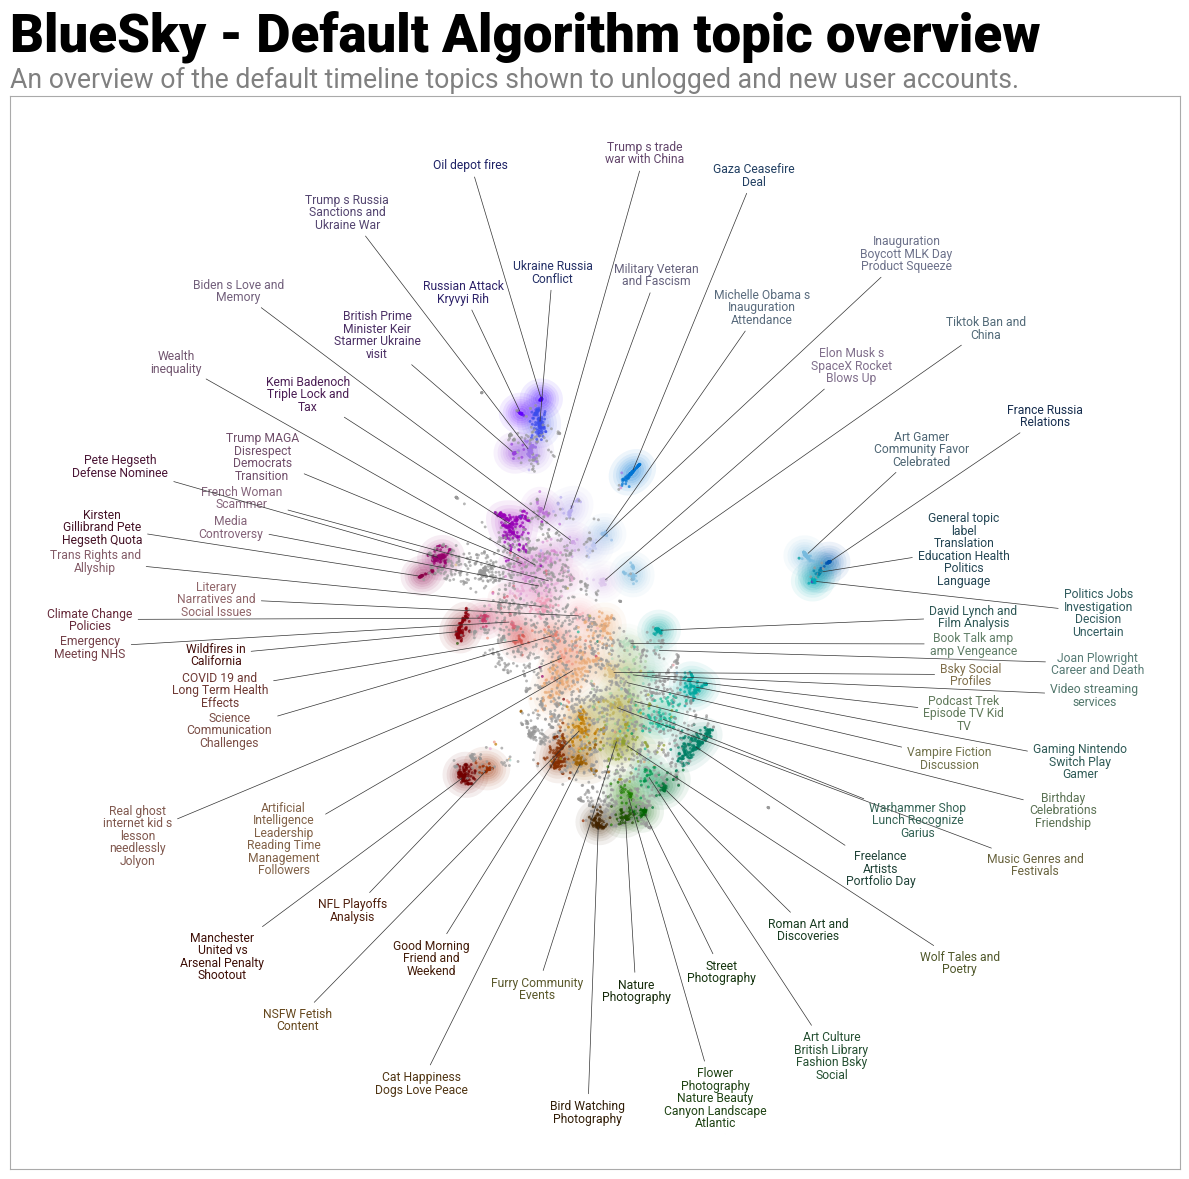

In [ ]:
import datamapplot
import matplotlib.pyplot as plt

datamapplot.create_plot(
    reduced_embeddings,
    all_labels,

    use_medoids=True,
    figsize=(12, 12),
    dpi=100,
    title="BlueSky - Default Algorithm topic overview",
    sub_title="An overview of the default timeline topics shown to unlogged and new user accounts.",
  
    add_glow=True,
    darkmode=False,
)

plt.tight_layout()


<InteractiveFigure width=100% height=800>
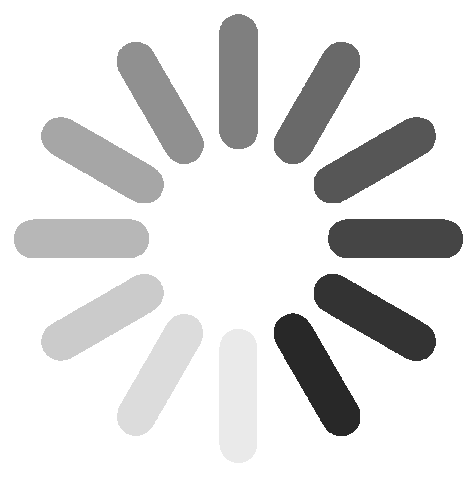

In [283]:
map = datamapplot.create_interactive_plot(
    reduced_embeddings,
    all_labels,
    use_medoids=True,
    title="BlueSky - Default Algorithm topic overview",
    sub_title="An overview of the default timeline topics shown to unlogged and new user accounts.",
    hover_text=df['Posts'],
    cluster_boundary_polygons=True,
    cluster_boundary_line_width=6,
)

map.save("bluesky_default_algorithm_22.html")

map

In [284]:
biggest_clusters = series_all_labels[1:6].index
biggest_clusters_sizes = series_all_labels[1:6].values

print(f"Biggest clusters: {biggest_clusters}")
print(f"Biggest clusters sizes: {biggest_clusters_sizes}")

Biggest clusters: Index(['Artificial Intelligence Leadership Reading Time Management Followers',
       'Freelance Artists Portfolio Day', 'Kemi Badenoch Triple Lock and Tax',
       'Good Morning Friend and Weekend',
       'Manchester United vs Arsenal Penalty Shootout'],
      dtype='object')
Biggest clusters sizes: [232 180 178 135 111]
